In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from fastai.tabular import *
from fastai.tabular.all import *
from fastai.vision.all import *
from fastai.data import *
import xgboost as xgb
import pickle

#display options for Dataframes
pd.options.display.max_seq_items = 20000
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)


In [5]:
xgb.__version__

'1.6.2'

In [2]:
#Import the relevant data
df=pd.read_csv("/Users/klaus/Documents/Jarvis Data/Data/Clean_Data.csv")
df.drop(columns=["about"],inplace=True)
df.head(n=10)

,name,type,employees,employees_latest,growth_stage,traffic_summary,launch_year,has_promising_founder,has_strong_founder,has_super_founder,total_funding,last_funding,company_status,last_updated_utc,created_utc,employee_3_months_growth_unique,job_openings,kpi_summary->last_update_date_utc,team->total,traffic->visitors,3d technology,artificial intelligence,augmented reality,autonomous & sensor tech,big data,blockchain,computer vision,connected device,deep learning,deep tech,hardware,iot internetofthings,machine learning,mobile app,nanotech,natural language processing,quantum technologies,recognition technology,virtual reality,Status
0,TrustYou,corporate,51-200,141.0,late growth,542K,2008.0,False,True,False,4.55,NaN,acquired,2022-09-01 03:11:44,2013-10-01 11:00:00,NaN,4,2022-03-06 13:57:59,11,542045.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Leads
1,pathfindr ApS,company,2-10,9.0,seed,NaN,2018.0,False,False,False,0.00,NaN,operational,2022-08-19 16:31:26,2022-07-19 16:09:49,NaN,0,2022-07-19 16:13:32,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Leads
2,HealthCaters,company,2-10,8.0,seed,NaN,2020.0,True,False,False,0.00,NaN,operational,2022-07-14 21:15:09,2021-11-08 15:45:03,NaN,0,2022-02-27 18:11:20,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Leads
3,Kollabo,company,11-50,14.0,early growth,16K,2018.0,False,False,False,2.78,2.20,operational,2022-08-25 15:32:53,2020-03-23 10:43:13,NaN,0,2022-02-08 05:00:03,5,16155.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Rejected
4,Kollabo,company,11-50,14.0,early growth,16K,2018.0,False,False,False,2.78,2.20,operational,2022-08-25 15:32:53,2020-03-23 10:43:13,NaN,0,2022-02-08 05:00:03,5,16155.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Rejected
5,KASURIA GmbH,company,2-10,8.0,seed,NaN,2021.0,False,False,False,0.00,NaN,operational,2022-08-24 22:51:55,2022-04-28 12:30:21,NaN,0,2022-04-28 13:07:50,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Leads
6,GovRadar,company,11-50,16.0,early growth,0.2K,2020.0,True,False,False,0.91,0.91,operational,2022-09-06 03:30:23,2020-11-03 19:46:04,58951.0,6,2022-05-19 03:33:23,1,178.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Prospect
7,Jiffsy,company,NaN,NaN,NaN,NaN,NaN,False,False,False,0.00,0.14,operational,2022-05-19 18:03:52,2021-11-08 19:18:18,NaN,0,2022-04-06 02:22:49,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rejected
8,eKidz.eu,company,11-50,15.0,early growth,10K,2017.0,False,False,False,1.45,0.45,operational,2022-09-03 12:56:50,2020-04-29 09:55:34,478893.0,0,2022-04-16 17:00:47,6,9648.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,Rejected
9,Aklimate,company,2-10,6.0,seed,NaN,2021.0,False,False,False,0.45,0.45,operational,2022-09-03 02:36:48,2021-10-15 13:56:30,532503.0,0,2022-01-21 13:28:37,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Prospect


In [3]:
#%pip install seaborn
import seaborn as sn
import matplotlib.pyplot as plt


#sn.heatmap(df.corr()["Status"], annot=True)
#plt.show()
df.corr()
#df.corr() > 0.9

,employees_latest,launch_year,has_promising_founder,has_strong_founder,has_super_founder,total_funding,last_funding,employee_3_months_growth_unique,job_openings,team->total,traffic->visitors,3d technology,artificial intelligence,augmented reality,autonomous & sensor tech,big data,blockchain,computer vision,connected device,deep learning,deep tech,hardware,iot internetofthings,machine learning,mobile app,nanotech,natural language processing,quantum technologies,recognition technology,virtual reality
employees_latest,1.000000,-0.056568,-0.007353,-0.006148,0.090958,0.064161,0.114570,-0.017881,0.018711,0.750731,0.991547,-0.002492,-0.007298,-0.001630,-0.001538,-0.004465,-0.003941,-0.002226,-0.002807,-0.002700,-0.007444,-0.002368,-0.002370,-0.005296,-0.002115,-0.000999,-0.001414,-0.000241,-0.002575,-0.001428
launch_year,-0.056568,1.000000,0.140991,-0.054336,-0.086801,-0.054601,-0.217363,-0.028863,-0.033699,-0.147629,-0.037801,-0.036198,0.030727,-0.029151,0.019746,-0.023104,0.006606,-0.016920,-0.023653,0.022375,-0.069425,-0.042449,-0.032329,0.002189,0.038746,-0.015300,0.009070,0.006339,-0.036063,-0.013163
has_promising_founder,-0.007353,0.140991,1.000000,-0.066213,-0.033184,-0.020932,-0.010669,0.048324,-0.022909,-0.007696,-0.003219,0.013836,0.025186,-0.020208,-0.008641,-0.025259,-0.013935,-0.001098,0.000172,0.014363,-0.021045,-0.004609,-0.019864,-0.000540,0.053102,-0.013894,-0.003680,-0.004499,-0.023518,-0.008242
has_strong_founder,-0.006148,-0.054336,-0.066213,1.000000,-0.016657,-0.006268,-0.030879,-0.183230,0.055050,0.198007,-0.007137,0.004777,0.149731,0.029661,0.040522,0.091660,0.038934,0.044192,0.031601,0.036412,0.139742,0.063695,0.045549,0.117607,0.067566,0.005024,0.018454,0.017727,0.054980,0.042153
has_super_founder,0.090958,-0.086801,-0.033184,-0.016657,1.000000,0.307679,0.042114,-0.061317,0.227234,0.328337,0.060891,0.003339,0.014375,0.016763,0.066414,0.026860,-0.011755,0.012335,-0.016708,-0.004500,0.052801,0.011462,0.035026,0.012076,0.023307,0.027788,-0.009061,-0.005364,-0.001624,0.006549
total_funding,0.064161,-0.054601,-0.020932,-0.006268,0.307679,1.000000,0.087625,-0.054944,0.215033,0.423722,0.001378,-0.002380,0.018622,0.010010,0.018943,0.017662,0.003022,0.018827,-0.001794,0.007336,0.020450,0.003902,0.017387,0.025591,0.046614,0.013972,-0.003890,0.000060,-0.000643,0.004053
last_funding,0.114570,-0.217363,-0.010669,-0.030879,0.042114,0.087625,1.000000,-0.064325,0.043826,0.106964,0.096171,-0.006016,-0.013215,-0.003255,-0.000689,-0.006085,-0.004365,-0.002134,-0.004200,-0.004224,0.045945,0.120478,0.108605,-0.007648,-0.004909,0.000607,-0.004191,-0.001098,-0.004777,-0.004896
employee_3_months_growth_unique,-0.017881,-0.028863,0.048324,-0.183230,-0.061317,-0.054944,-0.064325,1.000000,-0.103143,-0.061466,-0.009846,0.011057,-0.045165,-0.007668,-0.029693,-0.006165,0.016829,-0.026523,0.004663,-0.015316,-0.006835,-0.026465,-0.000823,-0.008288,-0.005541,-0.009685,-0.015044,-0.026748,0.006197,-0.009722
job_openings,0.018711,-0.033699,-0.022909,0.055050,0.227234,0.215033,0.043826,-0.103143,1.000000,0.136389,-0.002286,0.004648,0.023824,0.002031,0.025088,0.009805,-0.011922,0.016666,0.004160,0.006934,0.016598,0.019312,0.005132,0.018153,0.032213,-0.007316,0.058666,-0.000303,-0.008015,0.002031
team->total,0.750731,-0.147629,-0.007696,0.198007,0.328337,0.423722,0.106964,-0.061466,0.136389,1.000000,0.708083,0.019230,0.084515,0.021414,0.021791,0.081076,0.021358,0.046313,0.037520,0.047803,0.099750,0.046714,0.042233,0.078984,0.057302,0.021359,0.019787,0.004349,0.037035,0.024231


In [7]:
#see the ratio of missing data compared to other data
ratios = [ratio for ratio in (df.isna().sum()/len(df))] 
print([pair for pair in list(zip(df.columns, ratios)) if pair[1] > 0])

[('employees', 0.11083065626434144), ('employees_latest', 0.13813675998164296), ('growth_stage', 0.05759522716842588), ('traffic_summary', 0.3051858650757228), ('launch_year', 0.09889857732905002), ('last_funding', 0.664066085360257), ('employee_3_months_growth_unique', 0.3054153281321707)]


In [4]:
#Turn dependent variable to 0 and 1
df["Status"]=np.where((df["Status"]=="Rejected") | (df["Status"]=="To be rejected"), 0,1)
df["Status"]

0       1
1       1
2       1
3       0
4       0
       ..
4353    0
4354    0
4355    0
4356    0
4357    0
Name: Status, Length: 4358, dtype: int64

In [118]:
y=df.head()
df.drop(columns=["name","Status"])
cont_names, cat_names = cont_cat_split(y)


y_to = TabularPandas(y, procs=[Categorify, FillMissing, Normalize], cat_names=cat_names, cont_names=cont_names, 
                                 )

xgb_model.predict(y_to.xs)

array([0, 0, 0, 0, 0])

In [29]:
#Create Datablock from which training and test data can be extracted
cont_names, cat_names = cont_cat_split(df.drop(columns=["Status","name"]))
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize], cat_names=cat_names, cont_names=cont_names, 
                                 y_names="Status",y_block=CategoryBlock() ,splits=splits)
to.xs.iloc[:4]


,type,employees,growth_stage,traffic_summary,has_promising_founder,has_strong_founder,has_super_founder,company_status,last_updated_utc,created_utc,kpi_summary->last_update_date_utc,3d technology,artificial intelligence,augmented reality,autonomous & sensor tech,big data,blockchain,computer vision,connected device,deep learning,deep tech,hardware,iot internetofthings,machine learning,mobile app,nanotech,natural language processing,quantum technologies,recognition technology,virtual reality,employees_latest_na,launch_year_na,last_funding_na,employee_3_months_growth_unique_na,employees_latest,launch_year,total_funding,last_funding,employee_3_months_growth_unique,job_openings,team->total,traffic->visitors
2100,1,1,4,0,1,1,1,4,3490,3232,2042,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,-0.035794,0.274218,-0.097712,-0.032015,0.690447,-0.15308,-0.356722,-0.017133
3642,1,4,1,92,1,2,1,4,1375,418,3444,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,-0.026143,0.049601,-0.018597,-0.023930,-1.378474,-0.15308,0.360907,-0.017131
253,1,4,1,92,1,2,1,4,1600,1133,2543,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,-0.027590,0.274218,-0.053685,-0.028935,-0.009082,-0.15308,0.002092,-0.017131
202,1,4,1,0,1,1,1,4,1130,2813,1699,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,-0.028555,0.723451,-0.097712,-0.032015,-1.494229,-0.15308,-0.237117,-0.017133


In [112]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
y=np.array(to.ys["Status"])
X=pd.concat([X_train,X_test])



In [8]:

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [16]:
# estimate a value for the scale_pos_weight xgboost hyperparameter
from sklearn.datasets import make_classification
from collections import Counter

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 8.152


In [11]:
%pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 9.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [113]:

xgb_model = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight=8.399,random_state=42, colsample_bytree=0.9398611392758547, gamma= 0.4125663383463986, learning_rate= 0.08592149603644322, max_depth= 4, n_estimators= 113, subsample= 0.8092261699076477)
xgb_model.fit(X, y)

y_pred = xgb_model.predict(X_train)

print(confusion_matrix(y_train, y_pred))


[[2564  532]
 [  53  338]]


In [24]:
from scipy.stats import uniform, randint
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  3.3min finished


NameError: name 'report_best_scores' is not defined

In [31]:
xgb_model.best_ntree_limit

113

In [33]:
#saving the model
with open("xgb_model-0.1.0.pkl","wb") as f:
    pickle.dump(xgb_model,f)

In [28]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

AttributeError: `best_score` in only defined when early stopping is used.

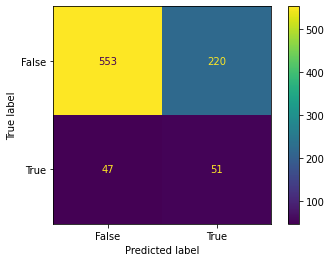

In [13]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt



cm_display.plot()
plt.show()